# Keras Tuner: Reuters Dataset

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [1]:
from tensorflow.keras.datasets import reuters

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [3]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [4]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [5]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [6]:
# Transformamos las etiquetas de salida en vectores
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

## División del conjunto de datos 

In [7]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [8]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

### Función para la realización del tuning

In [9]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import kerastuner as kt

Using TensorFlow backend


C:\Users\enric\AppData\Local\Temp\ipykernel_27924\2599867775.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [10]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(46, activation='softmax'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset'
)

Reloading Tuner from hp_dir\ruters_dataset\tuner0.json


In [12]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [13]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

In [14]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 88
Layers: 1


In [15]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    validation_data = (X_val, Y_val)
)

Epoch 1/20


281/281 [==============================] - 22s 65ms/step - loss: 2.5236 - accuracy: 0.5094 - val_loss: 1.7094 - val_accuracy: 0.6171
Epoch 2/20
281/281 [==============================] - 15s 54ms/step - loss: 1.4020 - accuracy: 0.6926 - val_loss: 1.3486 - val_accuracy: 0.6955
Epoch 3/20
281/281 [==============================] - 15s 54ms/step - loss: 1.0703 - accuracy: 0.7718 - val_loss: 1.1709 - val_accuracy: 0.7409
Epoch 4/20
281/281 [==============================] - 15s 53ms/step - loss: 0.8546 - accuracy: 0.8185 - val_loss: 1.0694 - val_accuracy: 0.7569
Epoch 5/20
281/281 [==============================] - 16s 57ms/step - loss: 0.6964 - accuracy: 0.8535 - val_loss: 0.9927 - val_accuracy: 0.7756
Epoch 6/20
281/281 [==============================] - 15s 54ms/step - loss: 0.5734 - accuracy: 0.8829 - val_loss: 0.9409 - val_accuracy: 0.7872
Epoch 7/20
281/281 [==============================] - 15s 53ms/step - loss: 0.4763 - accuracy: 0.9033 - val_loss: 0.9115 - val_accuracy: 0.7916
Epo

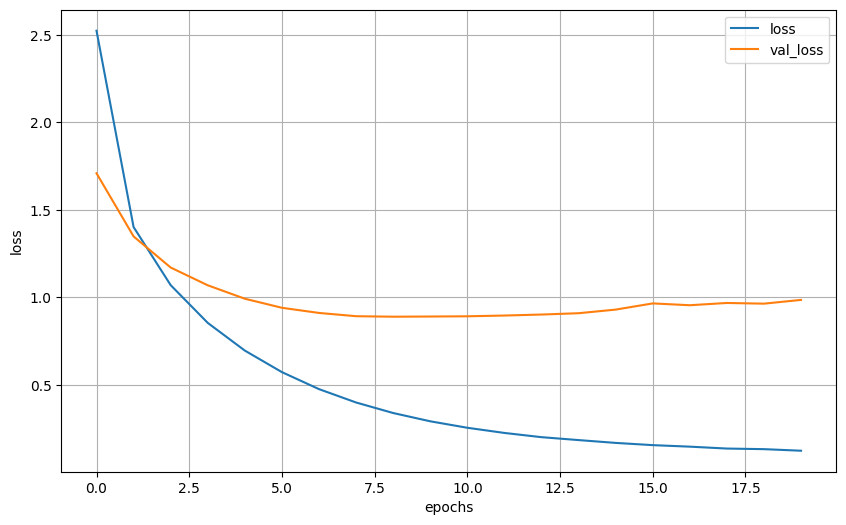

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

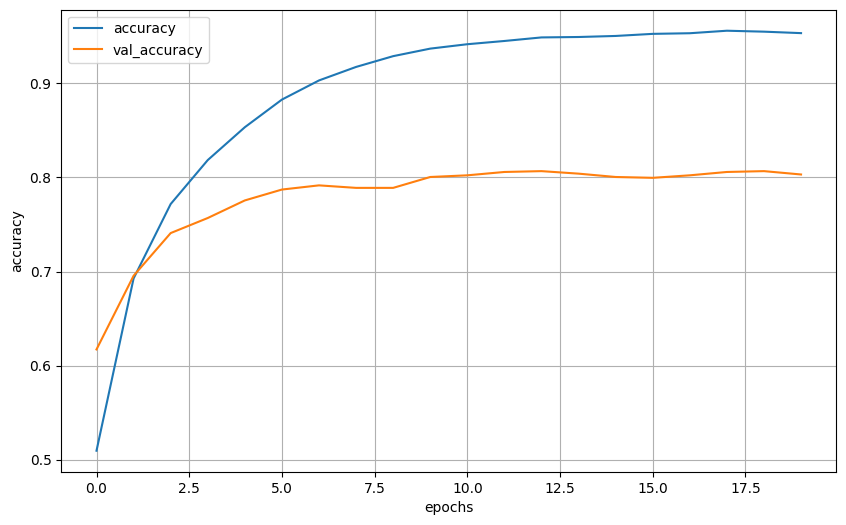

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [18]:
model.evaluate(X_test, Y_test)

36/36 [==============================] - 1s 16ms/step - loss: 0.9877 - accuracy: 0.7988


[0.9877252578735352, 0.7987533211708069]

In [19]:
model.predict(X_test).round(0)

36/36 [==============================] - 2s 14ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)